In [1]:
import json
import math
import os
import pickle as pk
import sys
sys.path.append('../utils/bbox')

import numpy as np
import numpy.matlib as npm
import scipy as sp
import scipy.ndimage
import scipy.spatial as sps

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams
from matplotlib.patches import Polygon

from scipy.ndimage import center_of_mass
from PIL import Image, ImageDraw
from bbox.min_bounding_rect import minBoundingRect

import fiftyone as fo
import fiftyone.utils.coco as fouc

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# The directory containing the source val images
data_path_val = "/home/martin/container/hail/detectron2/data/hail_20210620_r1/val/images/"
# The path to the COCO labels JSON file
labels_path_val = "/home/martin/container/hail/detectron2/data/hail_20210620_r1/val/annotations/instances_default.json"

# The directory containing the source test images
data_path_test = "/home/martin/container/hail/detectron2/data/hail_20210620_r1/test/lai/images/"
# The path to the COCO labels JSON file
labels_path_test = "/home/martin/container/hail/detectron2/data/hail_20210620_r1/test/lai/annotations/instances_default.json"

In [2]:
predictions_path_val = '/home/martin/container/hail/detectron2/output/logs/hparam_tuning/run-3/evaluation/val/sc005/coco_instances_results.json'
with open(predictions_path_val, 'r') as fp:
    predictions_info_val = json.load(fp)
#print (predictions_info_val[0])

# Import the gt dataset
val_dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path_val,
    labels_path=labels_path_val,
    label_field="ground_truth",
    include_id=True,
)
classes = val_dataset.default_classes

# And add model predictions
fouc.add_coco_labels(val_dataset,"predictions",predictions_info_val,classes, label_type="detections")

 100% |███████████████████| 33/33 [397.7ms elapsed, 0s remaining, 83.0 samples/s]      


In [3]:
predictions_path_test = '/home/martin/container/hail/detectron2/output/logs/hparam_tuning/run-3/evaluation/test/sc005/coco_instances_results.json'
with open(predictions_path_test, 'r') as fp:
    predictions_info_test = json.load(fp)
#print (predictions_info_test[0])

# Import the gt dataset
test_dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path_test,
    labels_path=labels_path_test,
    label_field="ground_truth",
    include_id=True,
)
classes = test_dataset.default_classes

# And add model predictions
fouc.add_coco_labels(test_dataset,"predictions",predictions_info_test,classes, label_type="detections")

 100% |███████████████████| 33/33 [313.0ms elapsed, 0s remaining, 105.4 samples/s]     


In [3]:
#SC Threshold: 0.05
results_val = val_dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth_detections",
    eval_key="eval_predictions",
)
results_val.print_report()

Evaluating detections...
 100% |███████████████████| 33/33 [1.0s elapsed, 0s remaining, 32.0 samples/s]         
              precision    recall  f1-score   support

        hail       0.37      0.98      0.54       249

   micro avg       0.37      0.98      0.54       249
   macro avg       0.37      0.98      0.54       249
weighted avg       0.37      0.98      0.54       249



In [5]:
#SC Threshold: 0.05
results_test = test_dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth_detections",
    eval_key="eval_predictions",
)
results_test.print_report()

Evaluating detections...
 100% |███████████████████| 33/33 [1.1s elapsed, 0s remaining, 30.8 samples/s]         
              precision    recall  f1-score   support

        hail       0.30      0.96      0.45       215

   micro avg       0.30      0.96      0.45       215
   macro avg       0.30      0.96      0.45       215
weighted avg       0.30      0.96      0.45       215



Evaluating detections...
 100% |███████████████████| 33/33 [418.2ms elapsed, 0s remaining, 78.9 samples/s]      
              precision    recall  f1-score   support

        hail       0.72      0.92      0.81       215

   micro avg       0.72      0.92      0.81       215
   macro avg       0.72      0.92      0.81       215
weighted avg       0.72      0.92      0.81       215



In [28]:
#SC Threshold: 0.90
results_val = val_dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth_detections",
    eval_key="eval_predictions",
)
results_val.print_report()

Evaluating detections...
 100% |███████████████████| 33/33 [1.1s elapsed, 0s remaining, 29.7 samples/s]         
              precision    recall  f1-score   support

        hail       0.37      0.98      0.54       249

   micro avg       0.37      0.98      0.54       249
   macro avg       0.37      0.98      0.54       249
weighted avg       0.37      0.98      0.54       249



In [30]:
results_val.metrics()

{'accuracy': 0.3684210526315789,
 'precision': 0.37065052950075644,
 'recall': 0.9839357429718876,
 'fscore': 0.5384615384615385,
 'support': 249}

In [ ]:
#Validation data set
from fiftyone import ViewField as F
fo.config.requirement_error_level = 0

eval_path = '/home/martin/container/hail/detectron2/hail_eval/'

conflist = np.linspace(0.05,0.99,95)

runs = ['run-0','run-1','run-2','run-3','run-4','run-5','run-6','run-7','run-8','run-9','run-10','run-11','run-12','run-13','run-14','run-15']

for run in runs:
    fscore = []
    recall = []
    precision = []
    tp = []
    fp = []
    fn = []
    score_dict = {}

    experiment_folder = '/home/martin/container/hail/detectron2/output/logs/hparam_tuning/'+run+'/'

    predictions_path_val = experiment_folder+'evaluation/val/sc005/coco_instances_results.json'
    with open(predictions_path_val, 'r') as fp:
        predictions_info_val = json.load(fp)
    print (predictions_info_val[0])

    # Import the gt dataset
    val_dataset = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path=data_path_val,
        labels_path=labels_path_val,
        label_field="ground_truth",
        include_id=True,
    )
    classes = val_dataset.default_classes

    # And add model predictions
    fouc.add_coco_labels(val_dataset,"predictions",predictions_info_val,classes, label_type="detections")


    for co in conflist:
        # Only contains detections with confidence >= co
        conf_tmp = val_dataset.filter_labels("predictions", F("confidence") >= co, only_matches=False)

        results_val = conf_tmp.evaluate_detections(
        "predictions",
        gt_field="ground_truth_detections",
        use_masks = True,
        eval_key="eval_predictions",
        )

        fscore.append(results_val.metrics()['fscore'])
        recall.append(results_val.metrics()['recall'])
        precision.append(results_val.metrics()['precision'])
        #tp.append(conf_tmp.sum("eval_tp"))
        #fp.append(conf_tmp.sum("eval_fp"))
        #fn.append(conf_tmp.sum("eval_fn"))

    score_dict['fscore'] = fscore
    score_dict['recall'] = recall
    score_dict['precision'] = precision
    #score_dict['tp'] = tp
    #score_dict['fp'] = fp
    #score_dict['fn'] = fn

    with open(eval_path+'scores_'+run+'.pkl', 'wb') as f:
        pk.dump(score_dict,f)

In [ ]:
#Test data set
from fiftyone import ViewField as F
fo.config.requirement_error_level = 0

eval_path = '/home/martin/container/hail/detectron2/hail_etest/'

conflist = np.linspace(0.05,0.99,95)

runs = ['run-0','run-1','run-2','run-3','run-4','run-5','run-6','run-7','run-8','run-9','run-10','run-11','run-12','run-13','run-14','run-15']

for run in runs:
    fscore = []
    recall = []
    precision = []
    tp = []
    fp = []
    fn = []
    score_dict = {}

    experiment_folder = '/home/martin/container/hail/detectron2/output/logs/hparam_tuning/'+run+'/'

    predictions_path_test = experiment_folder+'evaluation/test/sc005/coco_instances_results.json'
    with open(predictions_path_test, 'r') as fp:
        predictions_info_test = json.load(fp)
    #print (predictions_info_val[0])

    # Import the gt dataset
    test_dataset = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path=data_path_test,
        labels_path=labels_path_test,
        label_field="ground_truth",
        include_id=True,
    )
    classes = test_dataset.default_classes

    # And add model predictions
    fouc.add_coco_labels(test_dataset,"predictions",predictions_info_test,classes, label_type="detections")


    for co in conflist:
        # Only contains detections with confidence >= co
        conf_tmp = test_dataset.filter_labels("predictions", F("confidence") >= co, only_matches=False)

        results_test = conf_tmp.evaluate_detections(
        "predictions",
        gt_field="ground_truth_detections",
        use_masks = True,
        eval_key="eval_predictions",
        )

        fscore.append(results_test.metrics()['fscore'])
        recall.append(results_test.metrics()['recall'])
        precision.append(results_test.metrics()['precision'])
        #tp.append(conf_tmp.sum("eval_tp"))
        #fp.append(conf_tmp.sum("eval_fp"))
        #fn.append(conf_tmp.sum("eval_fn"))

    score_dict['fscore'] = fscore
    score_dict['recall'] = recall
    score_dict['precision'] = precision
    #score_dict['tp'] = tp
    #score_dict['fp'] = fp
    #score_dict['fn'] = fn

    with open(eval_path+'scores_'+run+'.pkl', 'wb') as f:
        pk.dump(score_dict,f)

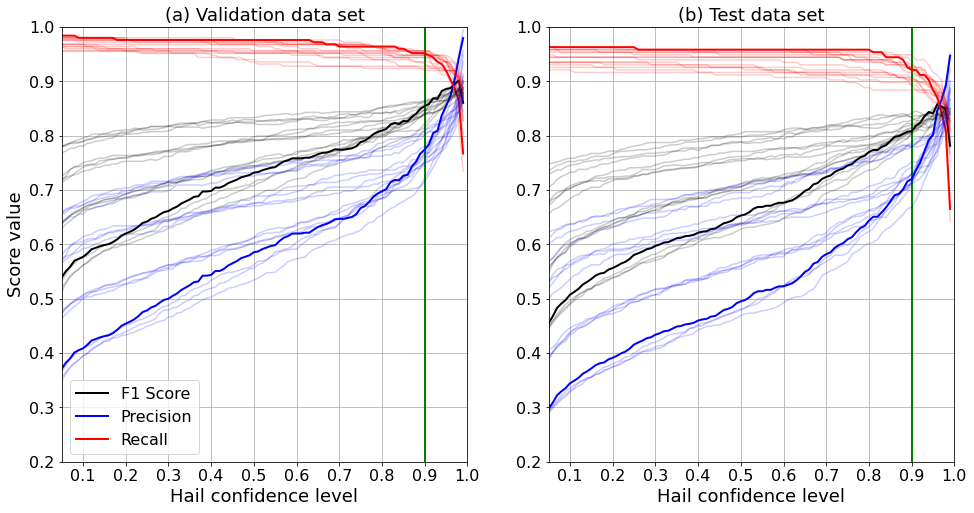

In [2]:
eval_path = '/home/martin/container/hail/detectron2/hail_eval/'
etest_path = '/home/martin/container/hail/detectron2/hail_etest/'

plot_dir = '/home/martin/container/hail/detectron2/hail_eplot/'

conflist = np.linspace(0.05,0.99,95)
runs = ['run-0','run-1','run-2','run-3','run-4','run-5','run-6','run-7','run-8','run-9','run-10','run-11','run-12','run-13','run-14','run-15']

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(16,8))

ax1.plot([0.9,0.9],[0,1],color='green',linewidth=2)
ax2.plot([0.9,0.9],[0,1],color='green',linewidth=2)

for run in runs:
    with open(eval_path+'scores_'+run+'.pkl', 'rb') as f:
        score_dict = pk.load(f)
    
    if run == 'run-3':
        ax1.plot(conflist,score_dict['fscore'],color="black",alpha=1,label='F1 Score',linewidth=2)
        ax1.plot(conflist,score_dict['precision'],color="blue",alpha=1,label='Precision',linewidth=2)
        ax1.plot(conflist,score_dict['recall'],color="red",alpha=1,label='Recall',linewidth=2)
    else:
        ax1.plot(conflist,score_dict['fscore'],color="black",alpha=0.2)
        ax1.plot(conflist,score_dict['precision'],color="blue",alpha=0.2)
        ax1.plot(conflist,score_dict['recall'],color="red",alpha=0.2)
        
for run in runs:
    with open(etest_path+'scores_'+run+'.pkl', 'rb') as f:
        score_dict = pk.load(f)
    
    if run == 'run-3':
        ax2.plot(conflist,score_dict['fscore'],color="black",alpha=1,label='F1 Score',linewidth=2)
        ax2.plot(conflist,score_dict['precision'],color="blue",alpha=1,label='Precision',linewidth=2)
        ax2.plot(conflist,score_dict['recall'],color="red",alpha=1,label='Recall',linewidth=2)
    else:
        ax2.plot(conflist,score_dict['fscore'],color="black",alpha=0.2)
        ax2.plot(conflist,score_dict['precision'],color="blue",alpha=0.2)
        ax2.plot(conflist,score_dict['recall'],color="red",alpha=0.2)
    
ax1.grid()
ax1.set_title('(a) Validation data set')
ax1.set_xlabel('Hail confidence level')
ax1.set_ylabel('Score value')
ax1.set_xticks(np.linspace(0,1,11))
ax1.set_xlim([0.05,1])
ax1.set_ylim([0.2,1])
ax1.legend()

ax2.grid()
ax2.set_title('(b) Test data set')
ax2.set_xlabel('Hail confidence level')
ax2.set_xticks(np.linspace(0,1,11))
ax2.set_xlim([0.05,1])
ax2.set_ylim([0.2,1])
#ax2.legend()

plt.savefig(plot_dir+'Scores_val_and_test.png',dpi=300,bbox_inches='tight',facecolor='white')

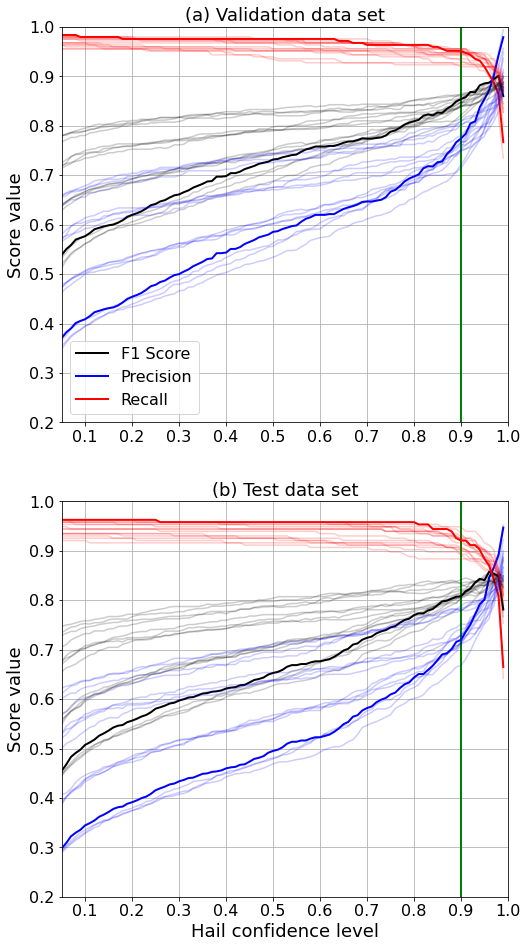

In [4]:
#Plot for ESSL Poster
eval_path = '/home/martin/container/hail/detectron2/hail_eval/'
etest_path = '/home/martin/container/hail/detectron2/hail_etest/'

plot_dir = '/home/martin/container/hail/poster/'

conflist = np.linspace(0.05,0.99,95)
runs = ['run-0','run-1','run-2','run-3','run-4','run-5','run-6','run-7','run-8','run-9','run-10','run-11','run-12','run-13','run-14','run-15']

fig, [ax1,ax2] = plt.subplots(2,1,figsize=(8,16))

ax1.plot([0.9,0.9],[0,1],color='green',linewidth=2)
ax2.plot([0.9,0.9],[0,1],color='green',linewidth=2)

for run in runs:
    with open(eval_path+'scores_'+run+'.pkl', 'rb') as f:
        score_dict = pk.load(f)
    
    if run == 'run-3':
        ax1.plot(conflist,score_dict['fscore'],color="black",alpha=1,label='F1 Score',linewidth=2)
        ax1.plot(conflist,score_dict['precision'],color="blue",alpha=1,label='Precision',linewidth=2)
        ax1.plot(conflist,score_dict['recall'],color="red",alpha=1,label='Recall',linewidth=2)
    else:
        ax1.plot(conflist,score_dict['fscore'],color="black",alpha=0.2)
        ax1.plot(conflist,score_dict['precision'],color="blue",alpha=0.2)
        ax1.plot(conflist,score_dict['recall'],color="red",alpha=0.2)
        
for run in runs:
    with open(etest_path+'scores_'+run+'.pkl', 'rb') as f:
        score_dict = pk.load(f)
    
    if run == 'run-3':
        ax2.plot(conflist,score_dict['fscore'],color="black",alpha=1,label='F1 Score',linewidth=2)
        ax2.plot(conflist,score_dict['precision'],color="blue",alpha=1,label='Precision',linewidth=2)
        ax2.plot(conflist,score_dict['recall'],color="red",alpha=1,label='Recall',linewidth=2)
    else:
        ax2.plot(conflist,score_dict['fscore'],color="black",alpha=0.2)
        ax2.plot(conflist,score_dict['precision'],color="blue",alpha=0.2)
        ax2.plot(conflist,score_dict['recall'],color="red",alpha=0.2)
    
ax1.grid()
ax1.set_title('(a) Validation data set')
#ax1.set_xlabel('Hail confidence level')
ax1.set_ylabel('Score value')
ax1.set_xticks(np.linspace(0,1,11))
ax1.set_xlim([0.05,1])
ax1.set_ylim([0.2,1])
ax1.legend()

ax2.grid()
ax2.set_title('(b) Test data set')
ax2.set_xlabel('Hail confidence level')
ax2.set_ylabel('Score value')
ax2.set_xticks(np.linspace(0,1,11))
ax2.set_xlim([0.05,1])
ax2.set_ylim([0.2,1])
#ax2.legend()

plt.savefig(plot_dir+'Scores_val_and_test.png',dpi=300,bbox_inches='tight',facecolor='white')

In [4]:
from fiftyone import ViewField as F
fo.config.requirement_error_level = 0
# Performs an IoU sweep so that mAP and PR curves can be computed
conf_tmp_val = val_dataset.filter_labels("predictions", F("confidence") >= 0.90, only_matches=False)
conf_tmp_test = test_dataset.filter_labels("predictions", F("confidence") >= 0.90, only_matches=False)

results_val90 = conf_tmp_val.evaluate_detections(
    "predictions",
    gt_field="ground_truth_detections",
    use_masks=True,
    compute_mAP=True,
    eval_key = 'eval',
)

print(results_val90.mAP())

results_test90 = conf_tmp_test.evaluate_detections(
    "predictions",
    gt_field="ground_truth_detections",
    use_masks=True,
    compute_mAP=True,
    eval_key = 'eval',
)

print(results_val90.mAP())
print(results_test90.mAP())

#plot_val = results_val.plot_pr_curves(classes=["hail"])
#plot_val.show()
#plot_test = results_test.plot_pr_curves(classes=["hail"])

Evaluating detections...
 100% |███████████████████| 33/33 [1.2s elapsed, 0s remaining, 28.7 samples/s]         
Performing IoU sweep...
 100% |███████████████████| 33/33 [689.6ms elapsed, 0s remaining, 47.9 samples/s]      
0.53096786884336
Evaluating detections...
 100% |███████████████████| 33/33 [857.3ms elapsed, 0s remaining, 38.5 samples/s]      
Performing IoU sweep...
 100% |███████████████████| 33/33 [626.9ms elapsed, 0s remaining, 52.6 samples/s]      
0.53096786884336
0.5033650415225813


In [91]:
print(np.size(results_val90.ious))
print(conf_tmp_val.sum("eval_fn"))
print(np.size(ious_val))
print(np.size(ious_test))

318
12
237
198


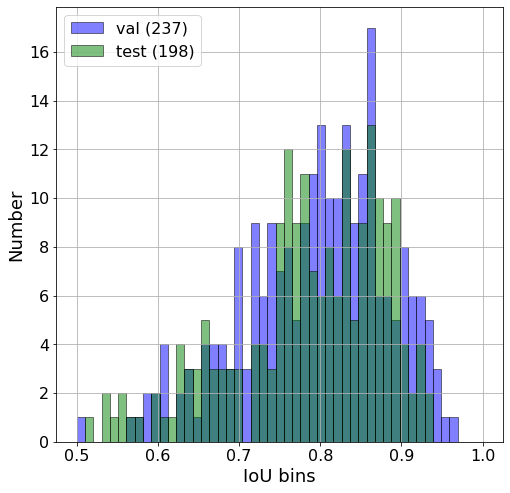

In [5]:
plot_dir = '/home/martin/container/hail/detectron2/hail_eplot/'
bins = np.linspace(0.5, 1, 50)

ious_val = results_val90.ious[results_val90.ious != None]
ious_test = results_test90.ious[results_test90.ious != None]

fig, ax = plt.subplots(figsize=(8,8))

plt.hist(ious_val, bins, alpha=0.5, label='val ('+str(np.size(ious_val))+')',color='blue',edgecolor='black')
plt.hist(ious_test, bins, alpha=0.5, label='test ('+str(np.size(ious_test))+')',color='green',edgecolor='black')
plt.legend(loc='upper left')
#plt.title('IoU histogram of TP matches ($C_{i} \geq 0.9$)')
plt.ylabel('Number')
plt.xlabel('IoU bins')
plt.grid()
plt.savefig(plot_dir+'IoU_val_and_test.png',dpi=300,bbox_inches='tight',facecolor='white')

In [60]:
results_val90.metrics()

{'accuracy': 0.7452830188679245,
 'precision': 0.7745098039215687,
 'recall': 0.9518072289156626,
 'fscore': 0.8540540540540541,
 'support': 249}

In [74]:
results_val90.precision[:,0,96]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
# Print some statistics about the total TP/FP/FN counts
from fiftyone import ViewField as F
print("TP: %d" % val_dataset.sum("eval_tp"))
print("FP: %d" % val_dataset.sum("eval_fp"))
print("FN: %d" % val_dataset.sum("eval_fn"))

# Create a view that has samples with the most false positives first, and
# only includes false positive boxes in the `predictions` field
view = (
    val_dataset
    .sort_by("eval_fp", reverse=True)
    .filter_labels("predictions", F("eval") == "fp")
)

TP: 245
FP: 416
FN: 4


In [8]:
session = fo.launch_app(view=view)

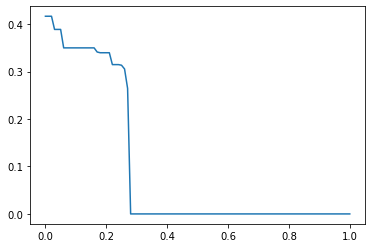

In [28]:
plt.plot(results.recall, results.precision[7,0,:])

In [53]:
# Print some statistics about the total TP/FP/FN counts
from fiftyone import ViewField as F
print("TP: %d" % val_dataset.sum("eval_tp"))
print("FP: %d" % val_dataset.sum("eval_fp"))
print("FN: %d" % val_dataset.sum("eval_fn"))

# Create a view that has samples with the most false positives first, and
# only includes false positive boxes in the `predictions` field
view = (
    val_dataset
    .sort_by("eval_fp", reverse=True)
    .filter_labels("predictions", F("eval") == "fp")
)

# Visualize results in the App
#session = fo.launch_app(view=view)

TP: 237
FP: 69
FN: 12


In [54]:
# Print some statistics about the total TP/FP/FN counts
from fiftyone import ViewField as F
print("TP: %d" % test_dataset.sum("eval_tp"))
print("FP: %d" % test_dataset.sum("eval_fp"))
print("FN: %d" % test_dataset.sum("eval_fn"))

# Create a view that has samples with the most false positives first, and
# only includes false positive boxes in the `predictions` field
view = (
    test_dataset
    .sort_by("eval_fp", reverse=True)
    .filter_labels("predictions", F("eval") == "fp")
)

# Visualize results in the App
#session = fo.launch_app(view=view)

TP: 198
FP: 77
FN: 17
